## ISMRM 2021 Software Demo: 
## Nonlinear Model-based Reconstruction for Quantitative MRI with BART

This tutorial uses the BART command-line inteface (CLI) (http://mrirecon.github.io/bart/) and presents how to perform nonlinear model-based reconstruction for quantitative MRI (T1 mapping, water-fat separation) using BART.

**Main Reference**

Wang X, Tan Z, Scholand N, Roeloffs V, Uecker M. [Physics-based Reconstruction Methods for Magnetic Resonance Imaging](https://arxiv.org/abs/2010.01403) Philos Trans R Soc A 2021;379:20200196.

**Authors**: [Xiaoqing Wang](mailto:xiaoqing.wang@med.uni-goettingen.de); [Zhengguo Tan](mailto:zhengguo.tan@med.uni-goettingen.de); [Nick Scholand](mailto:nick.scholand@med.uni-goettingen.de); [Christian Holme](mailto:christian.holme@med.uni-goettingen.de).

**Institution**: University Medical Center Göttingen

### 0. Setup BART

#### 0.1 Google colab

In [1]:
%%bash
## Check GPU Hardware

# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Install CUDA-10.1 if not already installed
    apt-get install cuda-10-1 cuda-drivers &> /dev/null

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda

else
    echo "GPU Information:"
    nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
    nvcc --version
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are necessary."
fi

GPU Type:
Tesla K80
GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1.


In [2]:
import os

# Set Library path for current CUDA version
os.environ['LD_LIBRARY_PATH'] = "/usr/local/cuda/lib64"

In [4]:
%%bash
## Install BART

# Install BARTs dependencies

apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

In [8]:
%%bash

# Download BART version

[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart

[ -d "bart" ] && echo "BART branch ${BRANCH} was downloaded successfully."

BART branch  was downloaded successfully.


Cloning into 'bart'...


In [9]:
%%bash

cd bart

# Switch to desired branch of the BART project
BRANCH="master"
git checkout $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=4
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# Compile BART with CUDA
make &> /dev/null

cd ..

Your branch is up to date with 'origin/master'.


Already on 'master'


In [2]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

In [41]:
!git clone https://github.com/mrirecon/bart-workshop

!cp bart-workshop/ismrm2021/model_based/* ./
!rm -rf bart-workshop

Cloning into 'bart-workshop'...
remote: Enumerating objects: 607, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 607 (delta 77), reused 172 (delta 73), pack-reused 429
Receiving objects: 100% (607/607), 168.42 MiB | 26.34 MiB/s, done.
Resolving deltas: 100% (245/245), done.
Checking out files: 100% (106/106), done.


#### 0.2 Local machine

In [ ]:
import os

os.environ["TOOLBOX_PATH"] = "/home/xwang/bart"
os.environ["PATH"] = os.getenv("TOOLBOX_PATH") + os.pathsep + os.getenv("PATH")

! echo "# The BART used in this notebook:"
! which bart
! echo "# BART version: "
! bart version

# The BART used in this notebook:
/home/xwang/bart/bart
# BART version: 
v0.7.00


## Part I. Model-based Reconstruction for IR-FLASH

# **1. Introduction**
#### 1.1 Inversion-prepared T1 mapping (single-shot)

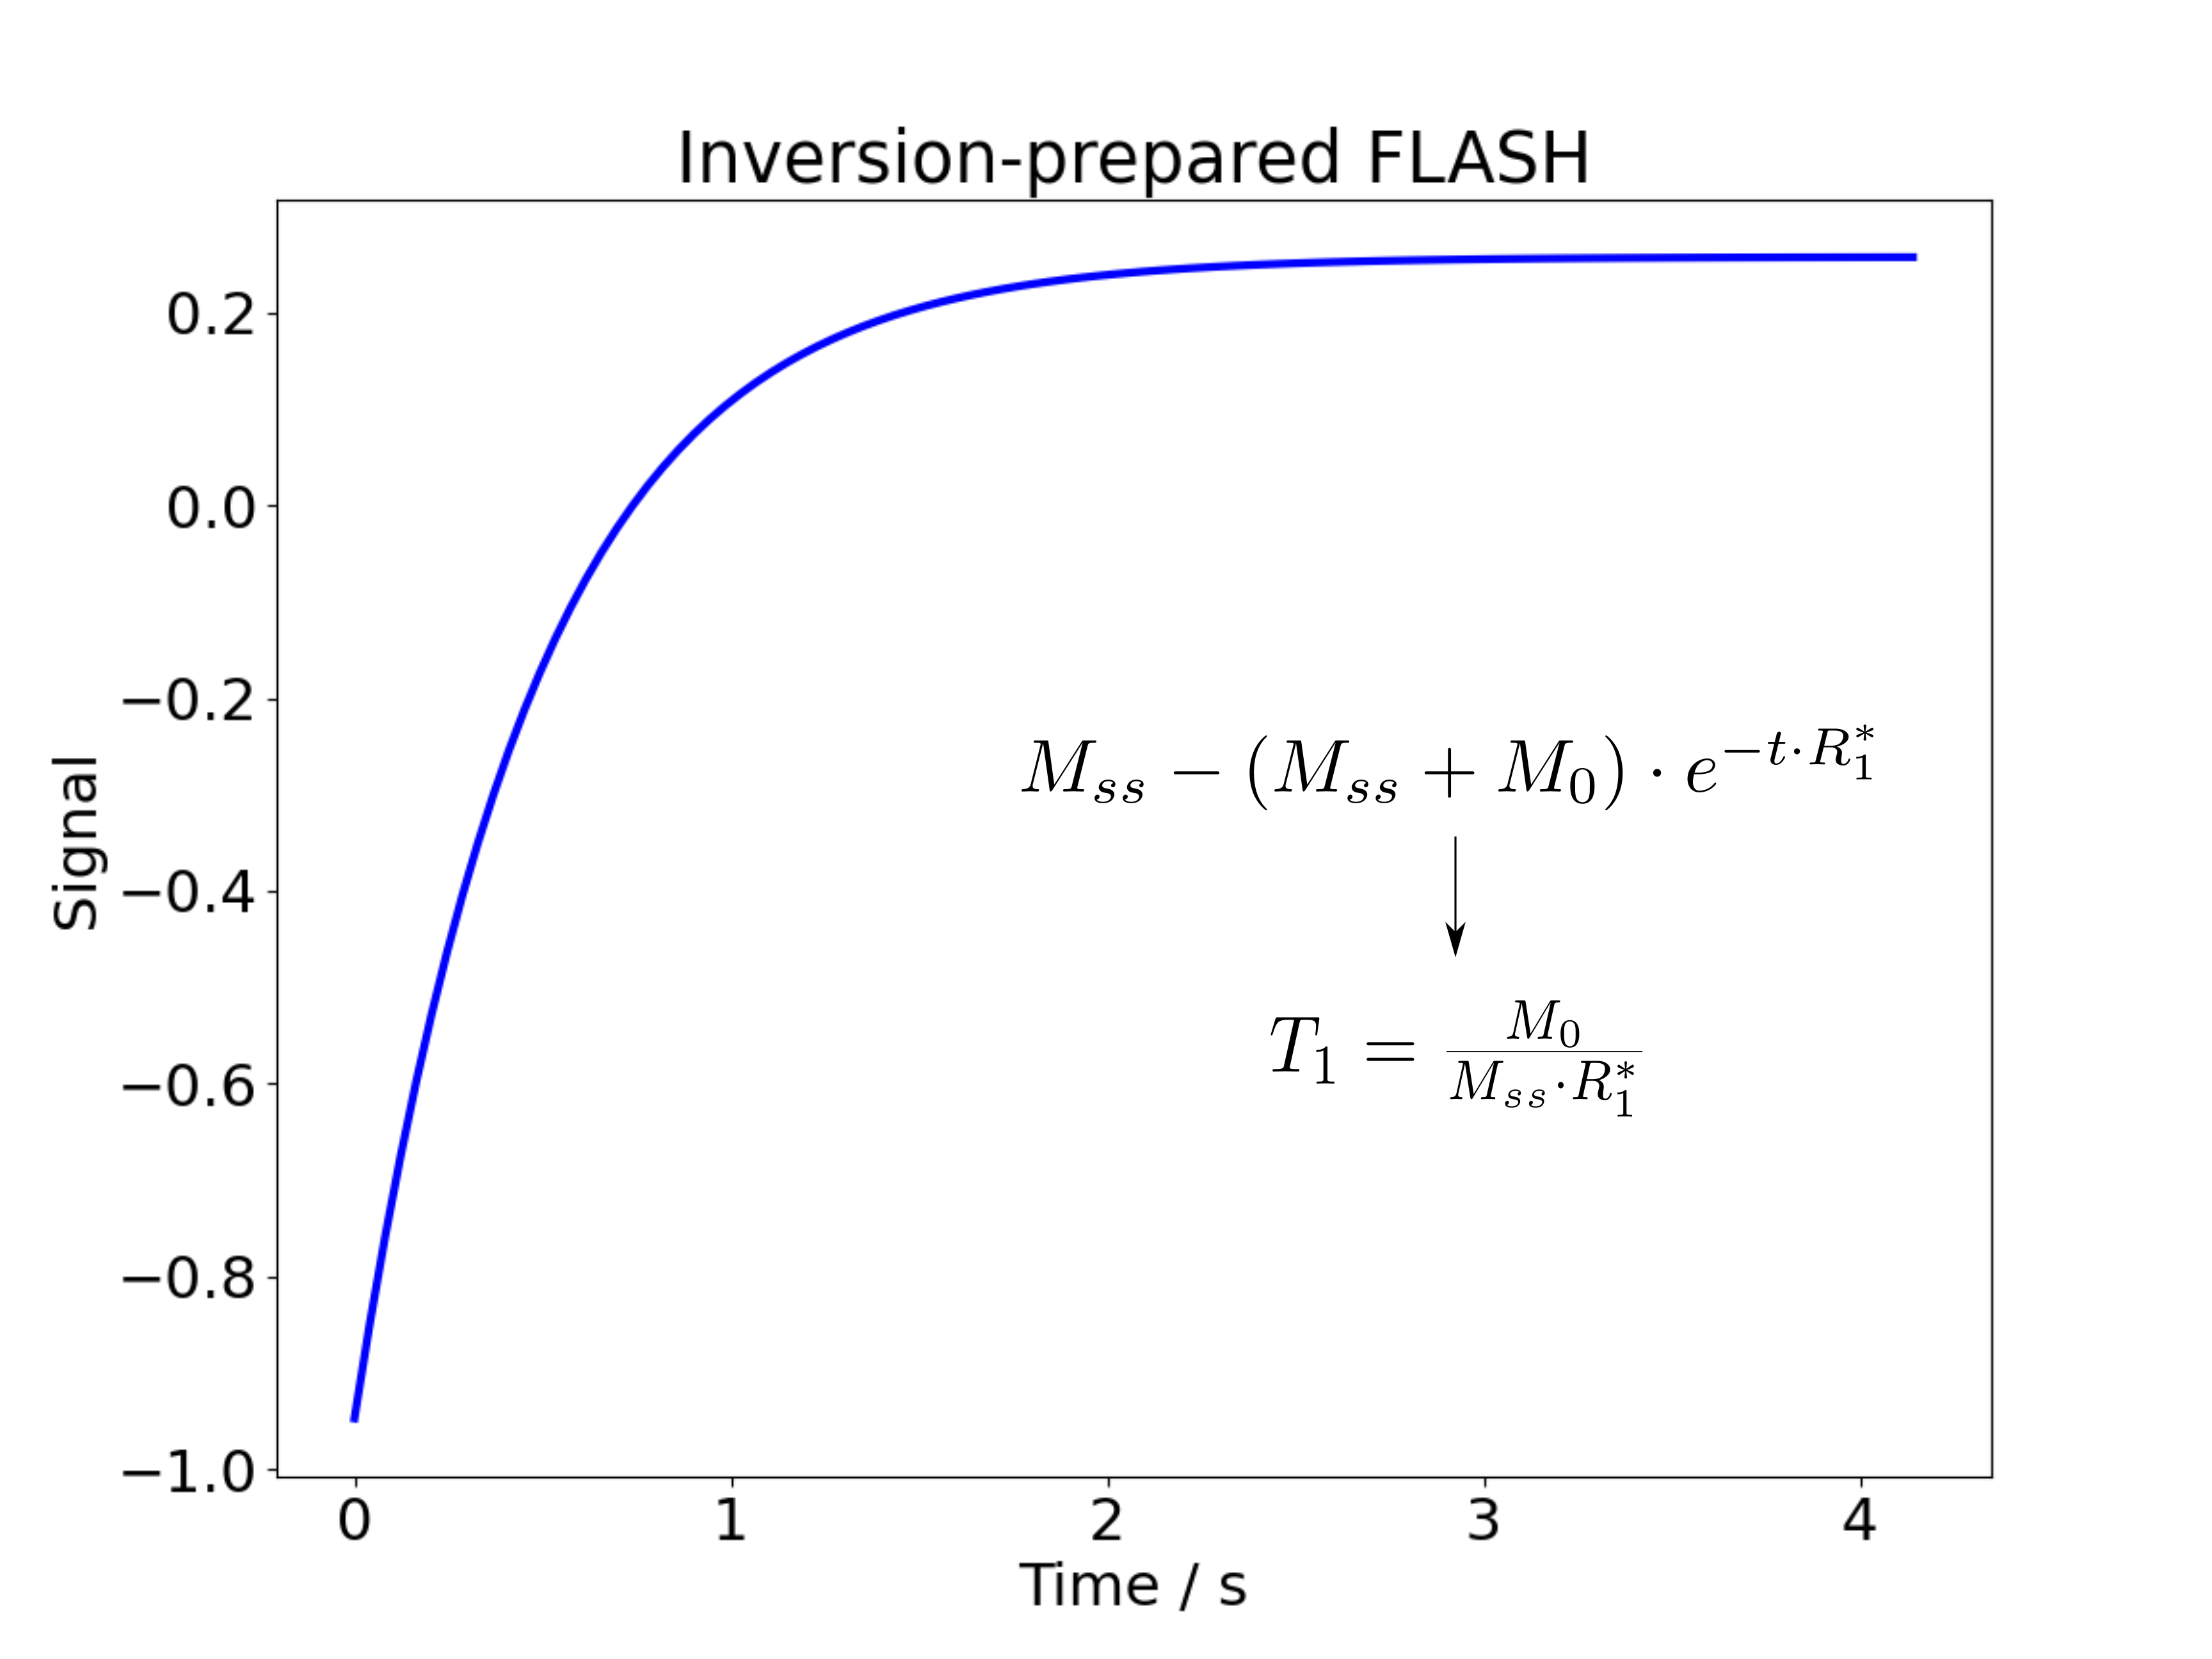

In [45]:
from IPython.display import Image
Image("IR_FLASH.png", width=600)

* General idea: Formulating the estimation of MR physical parameters directly from k-space as a nonlinear inverse problem

#### 1.2 Operator chain of parallel imaging and signal model (nonlinear)

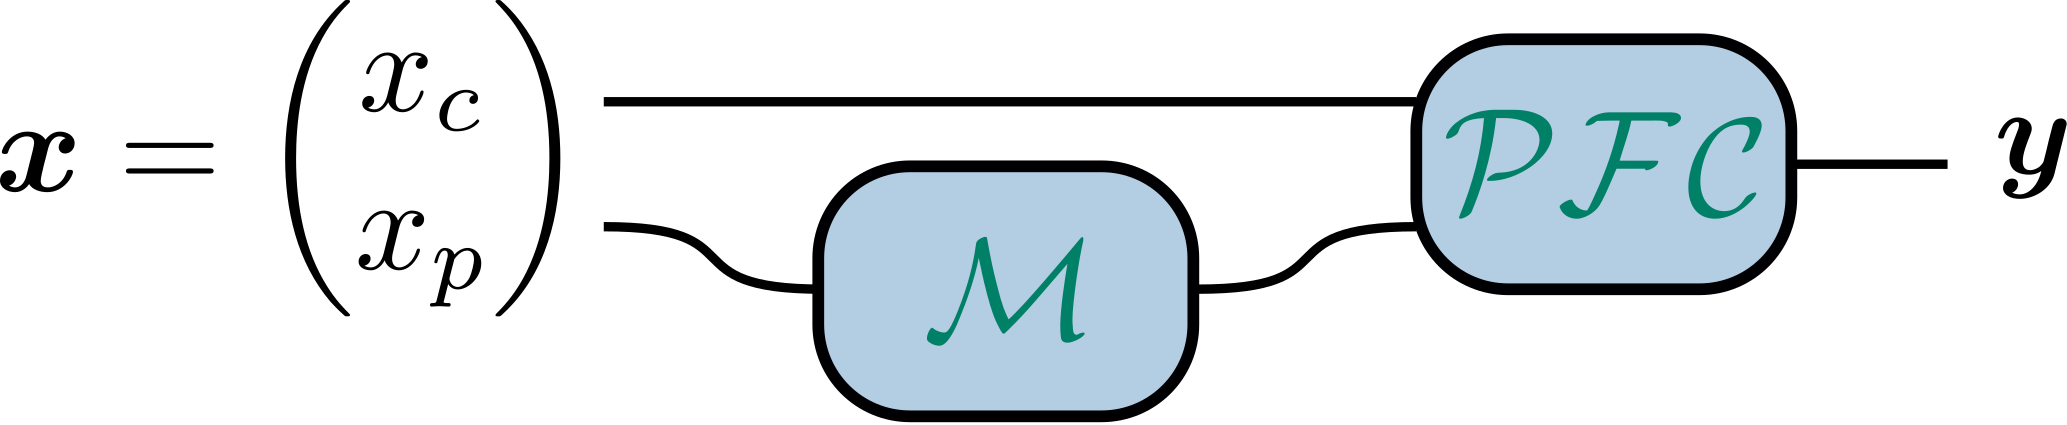

In [44]:
Image("operator_chain.png", width=350)

$$F: x \mapsto y = {\mathcal{P} \mathcal{F} C} \cdot {M(x)}$$
- $\mathcal{P}$ - sampling pattern
- $\mathcal{F}$ - Fourier transform
- $C$ - coil sensitivity maps
- $M(\cdot)$ - MR physics model
- $x$ - MR parameters
- $y$ - acquired kspace data

#### 1.3 Optimization

$$\hat{x} = \text{argmin}_{x}\|F(x) -y\|_{2}^{2} + \lambda \cdot R(x) $$

- We can use the iteratively regularized Gauss-Newton method (IRGNM) in BART to solve the above nonlinear inverse problem, i.e., the nonlinear problem can be linearly solved in each Gauss-Newton step,

$$\hat{x}_{n+1}= \text{argmin}_{x}\|DF(x_{n})(x−x_{n}) +F(x_{n})−y\|_{2}^{2} + \lambda \cdot R(x)$$

- $DF(x_{n})$ the Jacobian matrix of $F$ at the point $x_{n}$ of the $n$th Newton step
- Direct estimation of MR parameter maps (No fitting is needed)

Reference: Wang X, Roeloffs V, Klosowski J, Tan Z, Voit D, Uecker M, Frahm J. [Model-based T1 Mapping with Sparsity Constraints Using Single-Shot Inversion-Recovery Radial FLASH](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.26726). Magn Reson Med 2018;79:730-740.

#### 1.4 BART Commands

In [26]:
%%bash

#### moba now supports T1, T2, water-fat and T2* mapping
bart moba -h

Usage: moba [-r ...] [-L] [-F] [-G] [-m d] [-l d] [-i d] [-R f] [-T f] [-j f] [-u f] [-C d] [-s f] [-B f] [-b f:f] [-d d] [-f f] [-p <file>] [-J] [-M] [-g] [-I <file>] [-t <file>] [-o f] [-k] [--kfilter-1] [--kfilter-2] [-n] [--fat_spec_0] <kspace> <TI/TE> <output> [<sensitivities>]

Model-based nonlinear inverse reconstruction


-r <T>:A:B:C    generalized regularization options (-rh for help)
-L              T1 mapping using model-based look-locker
-F              T2 mapping using model-based Fast Spin Echo
-G              T2* mapping using model-based multiple gradient echo
-m model        Select the MGRE model from enum { WF = 0, WFR2S, WF2R2S, R2S, PHASEDIFF } [default: WFR2S]
-l 1/-l2         toggle l1-wavelet or l2 regularization.
-i iter         Number of Newton steps
-R redu         reduction factor
-T damp         damping on temporal frames
-j minreg       Minimum regu. parameter
-u rho          ADMM rho [default: 0.01]
-C iter         inner iterations
-s step         step s

### 2. Data Preparation 
#### The same as BART webinar 3 (https://github.com/mrirecon/bart-webinars/tree/master/webinar3).

2.1 Download raw data

2.2 Coil compression

2.3 Prepare radial trajectory (golden-angle) including gradient-delay correction

2.4 Prepare time vector

In [27]:
%%bash

## Download raw data
if [ ! -f IR-FLASH.cfl ]; then
  wget -q https://zenodo.org/record/4060287/files/IR-FLASH.cfl
  wget -q https://zenodo.org/record/4060287/files/IR-FLASH.hdr
fi

head -n2 IR-FLASH.hdr

# Dimensions
512 1 1 16 1 1 1 1 1 1 1020 1 1 1 1 1 


In [28]:
%%bash

## Coil compression
bart transpose 0 1 IR-FLASH ksp

# number of virtual coils
NUM_VCOILS=4 # for the purpose of fast computation
# coil compression
bart cc -A -p $NUM_VCOILS ksp ksp_cc

Done.


In [29]:
%%bash

# Assign dimensions to variables
READ=`bart show -d 0 IR-FLASH`
SPOKES=`bart show -d 2 IR-FLASH`
COILS=`bart show -d 3 IR-FLASH`
TIME=`bart show -d 10 IR-FLASH`
BR=$((READ/2))

## Prepare radial trajectory (golden-angle)
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$TIME traj

# Gradient Delay Correction
# Extract the steady-state data (data with less contrast change)
bart extract 10 920 1020 traj traj_extract
bart extract 10 920 1020 ksp_cc ksp_extract

# Transpose the 2nd and 10th dimension for the `estdelay` tool
bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

# Gradient delay estimation usign RING
GDELAY=$(bart estdelay -R traj_extract1 ksp_extract1)

echo "Gradient Delays: "$GDELAY

# Calculate the "correct" trajectory with known gradient delays
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$TIME -q $GDELAY trajn

Gradient Delays: -0.120232:0.163876:0.009013


In [30]:
%%bash

## Prepare time vector
TR=4100 #TR in [us]
BIN_SPOKES=20 # Bin data to save computational time 
TIME=`bart show -d 10 IR-FLASH`
NTIME=$((TIME/BIN_SPOKES))

# Create vector from 0 to NTIME
bart index 5 $NTIME tmp1
# use local index from newer bart with older bart
bart scale $(($BIN_SPOKES * $TR)) tmp1 tmp2
bart ones 6 1 1 1 1 1 $NTIME tmp1 
bart saxpy $((($BIN_SPOKES / 2) * $TR)) tmp1 tmp2 tmp3
bart scale 0.000001 tmp3 TI

# Reshape trajectory and data for model-based reconstruction
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 trajn traj_moba
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 ksp_cc ksp_cc_moba

# Resize data and trajectory for faster computation
bart resize -c 1 384 traj_moba traj_moba1
bart resize -c 1 384 ksp_cc_moba ksp_cc_moba1

echo "Trajectory:"
head -n2 traj_moba1.hdr

echo "Data:"
head -n2 ksp_cc_moba1.hdr

echo "TI:"
head -n2 TI.hdr''

Trajectory:
# Dimensions
3 384 20 1 1 51 1 1 1 1 1 1 1 1 1 1 
Data:
# Dimensions
1 384 20 4 1 51 1 1 1 1 1 1 1 1 1 1 
TI:
# Dimensions
1 1 1 1 1 51 1 1 1 1 1 1 1 1 1 1 


### 3. Nonlinear Model-based Reconstruction
3.1 Model-based reconstruction

3.2 Visualize results

In [37]:
# inversion-recovery Look-Locker T1 mapping

!bart moba -L -g -d4 -l1 -i8 -C100 -j0.09 -B0.0 -n -t traj_moba1 ksp_cc_moba1 TI reco_moba 

#-L  --- to select look-locker model
#-l1 --- to use l1-Wavelet regularization
#-i  --- number of Newton-steps
#-j  --- minimum regu. parameter
#-B  --- lower bound for relaxivity (R1s > 0)

# Note: There is no need of input of coil sensitivity maps, because we jointly estimate coils using model-based reconstruction

nufft kernel dims: [  1 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [480 480   1   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 391680 (vs. 12142080) + 11750400
ksp : [  1 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [480 480   1   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384  20   4   1  51   1   1   1   1   1   1   1   1   1   1 ]
cim : [480 480   1   4   1  51   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1 ]
tcmalloc: large alloc 1504051200 bytes == 0x559bc7bc6000 @  0x7f73156521e7 0x559ba8c71ae9 0x559ba8bb9862 0x559ba8bc9bee 0x559ba8bca81d 0x559ba8b87b2f 0x559ba8b715c8 0x559ba8b7151f 0x7f7306d86bf7 0x559ba8b712ea
tcmalloc: large alloc 1504

Writing 1 image(s)...done.


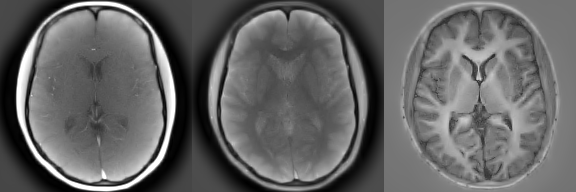

In [38]:
## Resize and Display the reconstructed maps, i.e., (Mss. M0, R1*)
!bart resize -c 0 192 1 192 reco_moba reco_maps
!bart resize -c 0 192 1 192 reco_moba reco_maps
!bart slice 6 0 reco_maps Mss
!bart slice 6 1 reco_maps M0
!bart slice 6 2 reco_maps R1s

!bart join 1 Mss M0 R1s tmp
!bart flip $(bart bitmask 0) tmp maps_all

!bart toimg -W maps_all maps_all.png
Image("maps_all.png", width=1000)

Finally, from the above parameters, we can calculate and visualize the estimated T1 map.

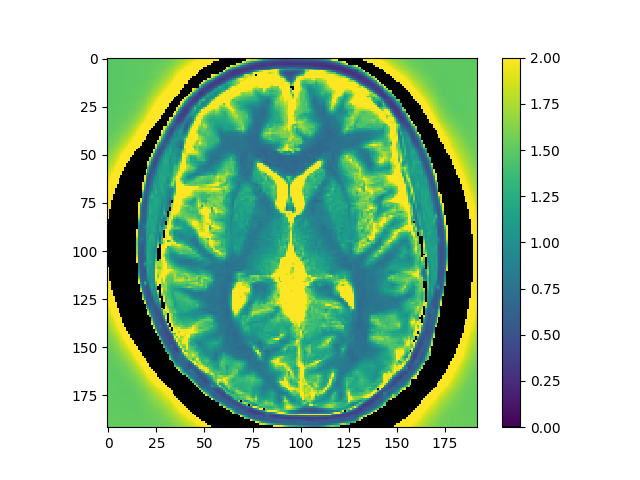

In [43]:
## use the "looklocker" tool in BART for post-processing
!bart looklocker -t0.2 -D15.3e-3 reco_maps tmp
!bart flip $(bart bitmask 0) tmp moba_T1map
!python3 save_maps.py moba_T1map viridis 0 2.0 moba_T1map.png
Image("moba_T1map.png", width=600)

Thank you for joining! Feel free to ask any questions:)

## Part II. Model-based Reconstruction on Multi-Echo Radial FLASH

This part of the notebook describes and demonstrates how to perform three-point water/fat separation and $B_0$ field mapping from multi-gradient-echo radial FLASH data. 

----
**For more information, please refer to this paper:**

Tan Z, Voit D, Kollmeier JM, Uecker M, Frahm J. [Dynamic water/fat separation and inhomogeneity mapping — joint estimation using undersampled triple‐echo multi‐spoke radial FLASH](https://doi.org/10.1002/mrm.27795). Magn Reson Med 2019;82:1000-1011.

----
**The data used in this tutorial is from this paper:**

Wang X, Tan Z, Scholand N, Roeloffs V, Uecker M. [Physics-based reconstruction methods for MRI](https://arxiv.org/abs/2010.01403). Philos Trans R Soc A 2021;379:20200196.

----

### 1. Multi-Echo Radial FLASH Sequence and *k*-Space Trajectory

![](https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/ME_FLASH.png?raw=1)
> Multiple gradient echoes are acquired after each RF excitation. 
> Every echo samples different *k*-space radial spoke with the use of triangular blip gradients.

### 2. Signal Modeling In the Case of Three-Echo Acquisition

The $m$th echo image ($\rho_m$) acquired at echo time TE$_m$ follows

$\rho_m = \big( \text{W} + \text{F} \cdot z_m \big) \cdot e^{i 2\pi f_{B_0} \text{TE}_m}$, 

with $\text{W}$ and $\text{F}$ being the water and fat images, and $f_{B_0}$ the $B_0$ field inhomogeneity map. The fat chemical shift phase modulation $z_m = \sum_{p=1}^6 \alpha_p e^{i2\pi f_p \text{TE}_m}$.

As shown previously in the software session, this signal model (implemented as a nonlinear operator in BART) can be chained with the parallel imaging model, and the complete unknown $x = (\text{W}, \text{F}, f_{B_0}, c_1, \cdots, c_N)^T$, where $c_j$ represents the coil sensitivity map.

### Step 1. Get the Raw Data

In [46]:
%%bash

if [ ! -f ME-FLASH.cfl ]; then
    wget -q https://zenodo.org/record/4060287/files/ME-FLASH.cfl
    wget -q https://zenodo.org/record/4060287/files/ME-FLASH.hdr
fi

Check the dimension of the raw data:

In [47]:
! head -n2 ME-FLASH.hdr

# Dimensions
400 231 1 20 1 1 1 1 1 1 55 1 1 1 1 1 


### Step 2. Prepare Raw Data for Image Reconstruction in BART

**3.1 Coil compression**

In [48]:
%%bash 

bart cc -A -p 8 ME-FLASH kdat

head -n2 kdat.hdr

Done.
# Dimensions
400 231 1 8 1 1 1 1 1 1 55 1 1 1 1 1 


**3.2 Preparation**

- Reorder *k*-space data; 
- Compute trajectory;
- Create echo time (TE) file.

In [49]:
%%bash

# --- dimensions ---

nr_echoes=7

nr_samples=$(bart show -d 0 kdat)

nr_tot_spokes=$(bart show -d 1 kdat)
nr_spokes=$(( nr_tot_spokes / nr_echoes ))

nr_coils=$(bart show -d 3 kdat)
nr_frames=$(bart show -d 10 kdat)


# --- k-space data ---

bart reshape $(bart bitmask 0 1 2) 1 ${nr_samples} ${nr_tot_spokes} kdat temp_kdat0

bart reshape $(bart bitmask 2 5) ${nr_echoes} ${nr_spokes} temp_kdat0 temp_kdat1

bart transpose 2 5 temp_kdat1 kdat_reorder

rm temp_kdat{0,1}.{hdr,cfl}

echo "# k-space data: "
head -n2 kdat_reorder.hdr
echo ""


# --- trajectory ---

bart traj -x ${nr_samples} -y ${nr_spokes} -t ${nr_frames} -r -s 2 -D -E -e ${nr_echoes} -c traj

echo "# trajectory: "
head -n2 traj.hdr
echo ""

# --- TE ---

bart index 5 ${nr_echoes} temp_incre

bart ones 6 1 1 1 1 1 ${nr_echoes} temp_one

bart scale 1.37 temp_one temp_TE1

bart saxpy 1.34 temp_incre temp_TE1 TE

rm temp_{incre,one,TE1}.{hdr,cfl}

echo "# TE: "
bart show TE

# k-space data: 
# Dimensions
1 400 33 8 1 7 1 1 1 1 55 1 1 1 1 1 

# trajectory: 
# Dimensions
3 400 33 1 1 7 1 1 1 1 55 1 1 1 1 1 

# TE: 
+1.370000e+00+0.000000e+00i	+2.710000e+00+0.000000e+00i	+4.050000e+00+0.000000e+00i	+5.390000e+00+0.000000e+00i	+6.730000e+00+0.000000e+00i	+8.070001e+00+0.000000e+00i	+9.410000e+00+0.000000e+00i


**2.3 Water/fat separation and $B_0$ field mapping via model-based reconstruction**

In [6]:
# --- use the first three echoes ---
# --- use only seven frames for demonstration purpose ---

! bart extract 5 0 3 10 23 30 kdat_reorder kdat_part
! bart extract 5 0 3 10 23 30 traj traj_part
! bart extract 5 0 3 TE TE_part

# --- moba ---

# bart moba 
# -G -m0 --> multi-gradient-echo model as listed above
# -b44:1 --> spatial smoothness constraint on B0 map 
# -i6 -R2 --> number of iterations and reduction factor
# -o1.5 --> overgrid factor
# -g --> use gpu
# -t traj_part kdat_part TE_part R_M0_2 C_M0_2

! bart moba -G -m 0 -b 44:1 -i 6 -R 2 -o 1.5 -d 4 -t traj_part kdat_part TE_part R_M0_2 C_M0_2

! bart resize -c 0 200 1 200 R_M0_2 R_WF
! bart resize -c 0 200 1 200 C_M0_2 C_WF

nufft kernel dims: [  1 400  33   1   1   3   1   1   1   1   7   1   1   1   1   1   1 ]
nufft psf dims:    [600 600   1   1   1   3   1   1   1   1   7   1   1   1   1   1   1 ]
nufft traj dims:   [  3 400  33   1   1   3   1   1   1   1   7   1   1   1   1   1   1 ]
Allocating 277200 (vs. 7837200) + 7560000
ksp : [  1 400  33   1   1   3   1   1   1   1   7   1   1   1   1   1   1 ]
cim : [600 600   1   1   1   3   1   1   1   1   7   1   1   1   1   1   1 ]
traj: [  3 400  33   1   1   3   1   1   1   1   7   1   1   1   1   1   1 ]
ksp : [  1 400  33   8   1   3   1   1   1   1   7   1   1   1   1   1 ]
cim : [600 600   1   8   1   3   1   1   1   1   7   1   1   1   1   1 ]
traj: [  3 400  33   1   1   3   1   1   1   1   7   1   1   1   1   1 ]
tcmalloc: large alloc 1935360000 bytes == 0x55802d78c000 @  0x7f7e91b9d1e7 0x558016f7eae9 0x558016ec6862 0x558016ed6bee 0x558016ed781d 0x558016e94b2f 0x558016e7e5c8 0x558016e7e51f 0x7f7e832d1bf7 0x558016e7e2ea
tcmalloc: large alloc 193536

**2.4 Visualization**

- **Display model-based reconstructed $\text{W}$, $\text{F}$ and $f_{B_0}$ maps**

In [7]:
%%bash

bart slice 10 6 R_WF R_WF6
bart flip $(bart bitmask 0) R_WF6 R_WF6_flip

python3 toimg_water_fat_B0.py R_WF6_flip R_WF6.png

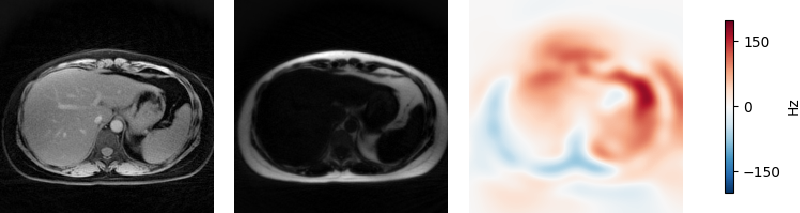

In [8]:
from IPython.display import Image
Image(filename='R_WF6.png')

* **Display model-based reconstructed coil sensitivity maps**

In [9]:
%%bash

bart slice 10 6 C_WF C_WF6
bart flip $(bart bitmask 0) C_WF6 C_WF6_flip

bart reshape $(bart bitmask 3 4) 4 2 C_WF6_flip C_WF6_flip_4x2

bart reshape $(bart bitmask 1 3) 800 1 C_WF6_flip_4x2 C_WF6_flip_1x2
bart reshape $(bart bitmask 0 4) 400 1 C_WF6_flip_1x2 C_WF6_flip_comb

bart toimg C_WF6_flip_comb C_WF6

Writing 1 image(s)...done.


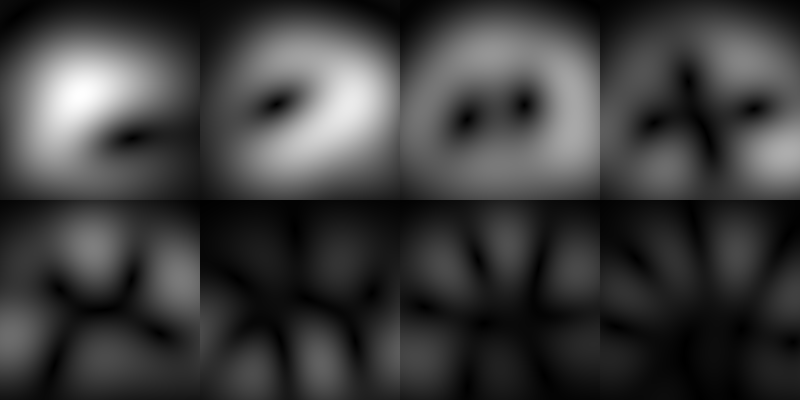

In [10]:
from IPython.display import Image
Image(filename='C_WF6.png')